In [45]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pylab
from scipy import stats
import seaborn as sns


# Regression Analysis: Seasonal Effects with Sklearn Linear Regression
In this notebook, you will build a SKLearn linear regression model to predict Yen futures ("settle") returns with *lagged* Yen futures returns. 

In [58]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [59]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


In [60]:
#yen_futures.drop('Change', axis = 1, inplace = True)
#yen_futures.drop('Percent Change', axis =1, inplace = True)
yen_futures.drop('Change', axis = 1, inplace = True)

In [61]:
yen_futures.head()

,Open,High,Low,Last,Settle,Volume,Previous Day Open Interest
Date,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,6959.0,19763.0,52072.0


# Data Preparation

### Returns

In [78]:
yen_futures['Returns'] = yen_futures['Settle'].pct_change()*100
yen_futures = yen_futures.dropna()
yen_futures.head()

,Open,High,Low,Last,Settle,Volume,Previous Day Open Interest,Returns,Lagged_Returns
Date,,,,,,,,,
1990-01-10,6905.0,6940.0,6885.0,6887.0,6887.0,34290.0,54735.0,-0.404917,-0.632275
1990-01-11,6904.0,6913.0,6892.0,6893.0,6893.0,19112.0,54018.0,0.087121,-0.404917
1990-01-12,6889.0,6927.0,6872.0,6873.0,6873.0,30146.0,55290.0,-0.290149,0.087121
1990-01-15,6892.0,6910.0,6886.0,6897.0,6897.0,11450.0,54868.0,0.349192,-0.290149
1990-01-16,6884.0,6904.0,6875.0,6897.0,6897.0,26242.0,54223.0,0.000000,0.349192


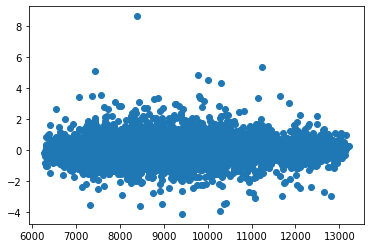

In [79]:
plt.scatter(yen_futures['Settle'], yen_futures['Returns'])


In [4]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
# YOUR CODE HERE!

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Return
Date,,,,,,,,,
2019-10-09,9381.0,9391.5,9330.5,9343.5,38.5,9338.0,99153.0,145470.0,-0.410601
2019-10-10,9343.5,9380.5,9293.5,9301.0,34.5,9303.5,159397.0,144474.0,-0.369458
2019-10-11,9308.5,9309.0,9240.0,9267.0,52.5,9251.0,158810.0,147471.0,-0.564304
2019-10-14,9259.0,9292.0,9250.5,9261.0,14.0,9265.0,69457.0,153902.0,0.151335
2019-10-15,9264.5,9280.0,9216.5,9220.0,43.5,9221.5,108342.0,151564.0,-0.469509


### Lagged Returns 

In [80]:
# Create a lagged return using the shift function
yen_futures['Lagged_Returns'] = yen_futures.Returns.shift()
yen_futures = yen_futures.dropna()
yen_futures.head()

,Open,High,Low,Last,Settle,Volume,Previous Day Open Interest,Returns,Lagged_Returns
Date,,,,,,,,,
1990-01-11,6904.0,6913.0,6892.0,6893.0,6893.0,19112.0,54018.0,0.087121,-0.404917
1990-01-12,6889.0,6927.0,6872.0,6873.0,6873.0,30146.0,55290.0,-0.290149,0.087121
1990-01-15,6892.0,6910.0,6886.0,6897.0,6897.0,11450.0,54868.0,0.349192,-0.290149
1990-01-16,6884.0,6904.0,6875.0,6897.0,6897.0,26242.0,54223.0,0.000000,0.349192
1990-01-17,6884.0,6920.0,6883.0,6897.0,6897.0,16098.0,53624.0,0.000000,0.000000


In [87]:
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
train = yen_futures.loc[:'2018']
test = yen_futures.loc['2018':'2019']

In [88]:
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
# YOUR CODE HERE!
X_train = train["Lagged_Returns"].to_frame()
X_test = test["Lagged_Returns"].to_frame()
y_train = train["Returns"]
y_test = test["Returns"]

### Train Test Split

In [91]:
X_train

,Lagged_Returns
Date,
1990-01-11,-0.404917
1990-01-12,0.087121
1990-01-15,-0.290149
1990-01-16,0.349192
1990-01-17,0.000000
...,...
2018-12-24,-0.187545
2018-12-26,0.834485
2018-12-27,-0.893346


# Linear Regression Model

In [95]:
# Create a Linear Regression model and fit it to the training data
from sklearn.linear_model import LinearRegression

# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

# Make predictions using the Testing Data

Note: We want to evaluate the model using data that it has never seen before, in this case: X_test.

In [96]:
# Make a prediction of "y" values using just the test dataset
predictions = model.predict(X_test)

In [98]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results["Predicted Return"] = predictions
Results.head(2)

,Returns,Predicted Return
Date,,
2018-01-02,0.297285,0.003913
2018-01-03,-0.240479,0.003106


array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

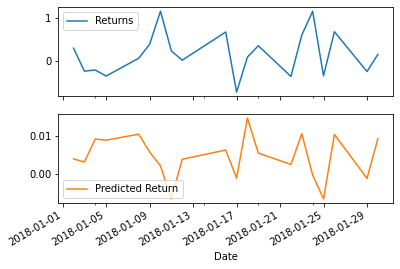

In [100]:
# Plot the first 20 predictions vs the true values
Results[:20].plot(subplots=True)

# Out-of-Sample Performance

Evaluate the model using "out-of-sample" data (X_test and y_test)

In [103]:
from sklearn.metrics import mean_squared_error
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
mse = mean_squared_error(
    Results["Returns"],
    Results["Predicted Return"]
)


# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
rmse = np.sqrt(mse)
print(f"Out-of-Sample Root Mean Squared Error (RMSE): {rmse}")

#test data > training error means the model is overfit. 

Out-of-Sample Root Mean Squared Error (RMSE): 0.4136399226116122


# In-Sample Performance

Evaluate the model using in-sample data (X_train and y_train)

In [104]:
#My data slightly off... 
in_sample_results = y_train.to_frame()

# Add a column of "in-sample" predictions to that DataFrame:  
in_sample_results["In-sample Predictions"] = model.predict(X_train)

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
in_sample_mse = mean_squared_error(
    in_sample_results["Returns"],
    in_sample_results["In-sample Predictions"]
)

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
in_sample_rmse = np.sqrt(in_sample_mse)
print(f"In-sample Root Mean Squared Error (RMSE): {in_sample_rmse}")

#compare in sample and out of sample to check overfit (can't be generalized)

In-sample Root Mean Squared Error (RMSE): 0.6980383300663885


# Conclusions

YOUR CONCLUSIONS HERE!

The predicted returns are not reflective of the actual returns, so this model is not good for this instance. The testing error is less than the training error, which reflects the model is not overfit. 